In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from bandit import *

In [165]:
num_actions = 10
num_worlds = 100
steps_per_epoch = 5000

worlds = [World(i, num_actions) for i in range(num_worlds)]

agent_creators = [
    lambda: RandomAgent(num_actions, steps_per_epoch),
    lambda: GreedyAgent(num_actions, steps_per_epoch),
    lambda: EGreedyAgent(num_actions, steps_per_epoch, eps=0.01),
    lambda: EGreedyAgent(num_actions, steps_per_epoch, eps=0.1),
]

In [166]:
with Pool(10) as pool:
    args = [
        (world, create_agent(), steps_per_epoch) for world in worlds for create_agent in agent_creators
    ]
    world_agent_pairs = pool.starmap(run_world, args)

In [167]:
from collections import defaultdict

agent_name_to_index = {}

results = np.zeros((num_worlds, len(agent_creators)))

for (world, agent) in world_agent_pairs:
    col_id = agent_name_to_index.setdefault(agent.name, len(agent_name_to_index))
    results[world.id][col_id] = agent.total_reward()

In [168]:
# import matplotlib.pyplot as plt

# width = 0.35       # the width of the bars: can also be len(x) sequence
# fig, ax = plt.subplots()
# fig.set_size_inches(23,15)

# labels = [f"{i}" for i in range(len(worlds))]

# prev_scores = np.zeros(len(worlds))
# for agent_name, index in agent_name_to_index.items():
#     agent_scores = results[:,index]
#     ax.bar(labels, agent_scores, width, label=agent_name, bottom=prev_scores)        
#     prev_scores += agent_scores
              
# ax.set_ylabel('Scores')
# ax.set_title('Scores by agent')
# ax.legend()

# plt.show()

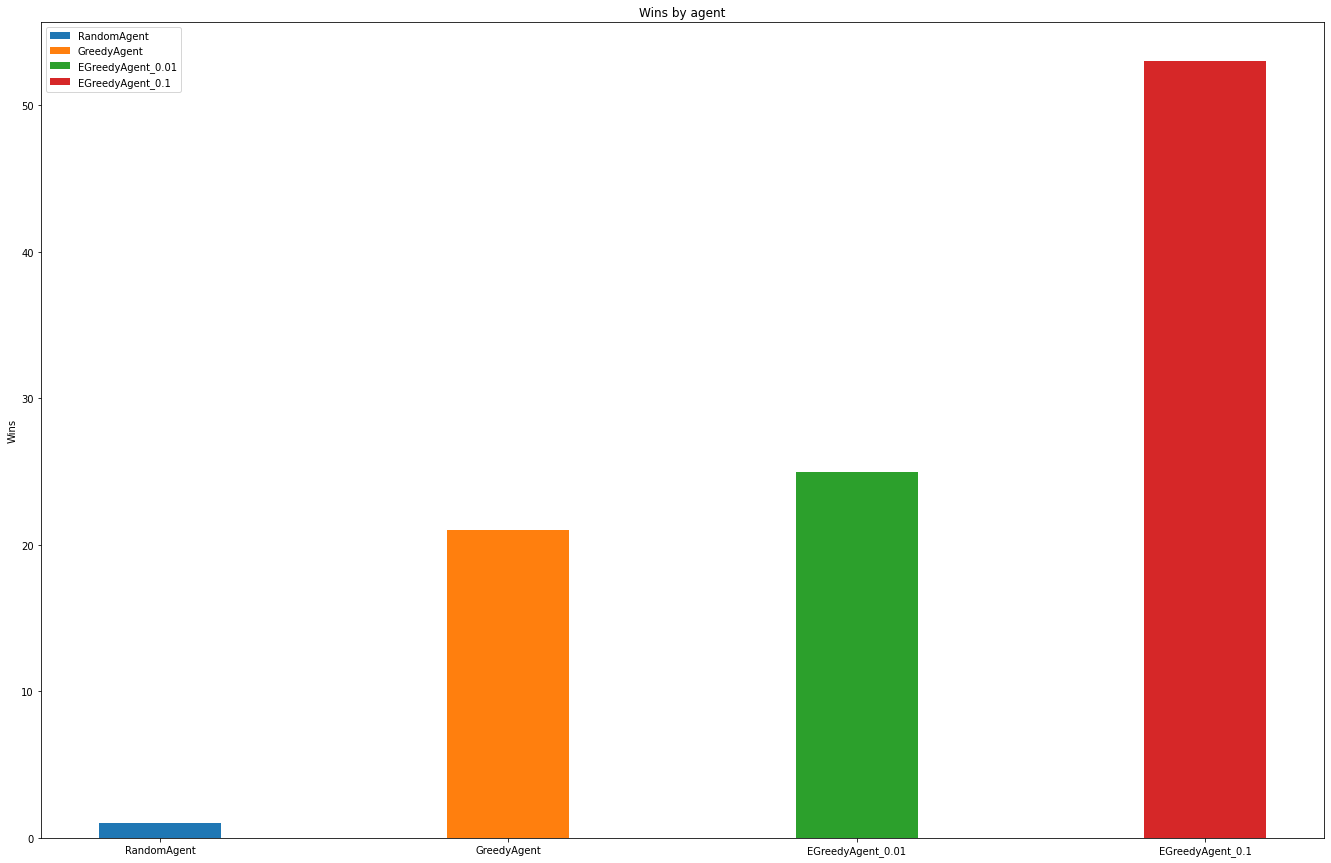

In [169]:
import matplotlib.pyplot as plt

unique, counts = np.unique(np.argmax(results, axis=1), return_counts=True)
index_to_wins = {index: count for index, count in zip(unique, counts)}

width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
fig.set_size_inches(23,15)

agent_index_to_name = {v: k for k, v in agent_name_to_index.items()}
labels = list(agent_name_to_index.keys())

for name, index in agent_name_to_index.items():  
    wins = index_to_wins.get(index, 0)
    ax.bar([name], wins, width, label=name)
              
ax.set_ylabel('Wins')
ax.set_title('Wins by agent')
ax.legend()

plt.show()

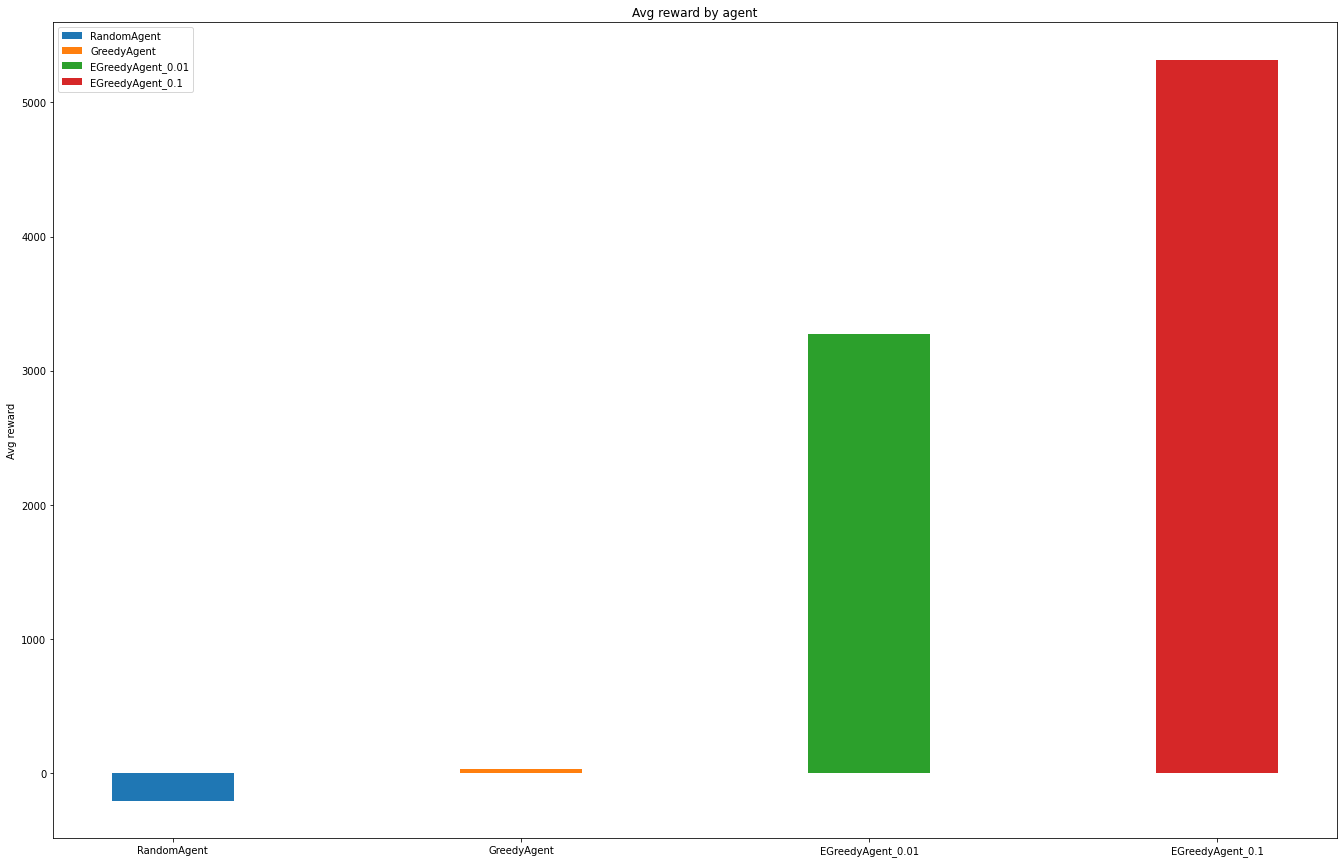

In [170]:
import matplotlib.pyplot as plt

avg_reward = np.average(results, axis=0)

width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
fig.set_size_inches(23,15)

labels = list(agent_name_to_index.keys())

for name, index in agent_name_to_index.items():  
    value = avg_reward[index]
    ax.bar([name], value, width, label=name)
              
ax.set_ylabel('Avg reward')
ax.set_title('Avg reward by agent')
ax.legend()

plt.show()